In [1]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
goalkeeper_data_df = pd.read_csv('/kaggle/input/combined-data/goalkeeper_data.csv')
outfield_data_df = pd.read_csv('/kaggle/input/combined-data/outfield_data.csv')
model_performance_df = pd.read_csv('/kaggle/input/model-performance/model_performance.csv')
nn_results_df = pd.read_csv('/kaggle/input/model-performance/nn_results.csv')

# Splitting the dataset
First we split the dataset (outfield players and goalkeepers) into training and test data.
* Note the imbalance of dataset because it is expected that only a handful of players get injured during the course of the season.
* We want to transform categorical features such as 'League', 'Position' and 'Categorized Position' into numerical values to feed into the model using One Hot Encoding
* Target variables are 'Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate'; the things we would want to predict

In [3]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(df, cols):
    # Create a OneHotEncoder object
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Fit and transform the 'Position' column
    df_encoded = pd.DataFrame(encoder.fit_transform(df[cols]))
    df_encoded.columns = encoder.get_feature_names_out()

    df.drop(cols, axis=1, inplace=True)
    return pd.concat([df, df_encoded], axis = 1)

outfield_cols = ['Position', 'Categorized Position', 'League']
gk_cols = ['League']
outfield_data_df = one_hot_encoding(outfield_data_df, outfield_cols)
goalkeeper_data_df = one_hot_encoding(goalkeeper_data_df, gk_cols)

In [4]:
from sklearn.model_selection import train_test_split

# Select features (X) and target variable (y)
outfield_X = outfield_data_df.drop(['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate', 'Name', 'Birthday', 'Club', 'Injuries', 'Type of Injury', 'Categorized Injuries'], axis=1)
outfield_y = outfield_data_df[['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']]
goalkeeper_X = goalkeeper_data_df.drop(['Position', 'Categorized Position', 'Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate', 'Name', 'Birthday', 'Club', 'Injuries', 'Type of Injury', 'Categorized Injuries'], axis=1)
goalkeeper_y = goalkeeper_data_df[['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']]

# Split the data into training and testing sets
outfield_X_train, outfield_X_test, outfield_y_train, outfield_y_test = train_test_split(outfield_X, outfield_y, test_size=0.2, random_state=42)
goalkeeper_X_train, goalkeeper_X_test, goalkeeper_y_train, goalkeeper_y_test = train_test_split(goalkeeper_X, goalkeeper_y, test_size=0.2, random_state=42)

In [5]:
# Export datasets
outfield_X_train.to_csv('outfield_X_train.csv', index=False)
outfield_X_test.to_csv('outfield_X_test.csv', index=False)
outfield_y_train.to_csv('outfield_y_train.csv', index=False)
outfield_y_test.to_csv('outfield_y_test.csv', index=False)
goalkeeper_X_train.to_csv('goalkeeper_X_train.csv', index=False)
goalkeeper_X_test.to_csv('goalkeeper_X_test.csv', index=False)
goalkeeper_y_train.to_csv('goalkeeper_y_train.csv', index=False)
goalkeeper_y_test.to_csv('goalkeeper_y_test.csv', index=False)

from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler

# Perform standardisaion
scaler = MinMaxScaler()
outfield_X_train = scaler.fit_transform(outfield_X_train)
outfield_X_test = scaler.fit_transform(outfield_X_test)

goalkeeper_X_train = scaler.fit_transform(goalkeeper_X_train)
goalkeeper_X_test = scaler.fit_transform(goalkeeper_X_test)

# Analysis of training data
We want to identify the general behaviour of our training dataset. We can do so by reducing the dimensionality using Principle Component Analysis. This helps us:
* Reduce dimensions of our features
* Identify any linear seperability between targets

## PCA Analysis
PCA essentially creates as many principal components as there are features in our data. These components are arranged in order of importance, indicating how much of the PCA variance of our data is explained by each component. Typically we want to keep about 80% of the variance, and from the result below, the number of components that we should keep is around 12.5 to 15.

[0.17150201 0.12437322 0.10420449 0.07853144 0.07303621 0.05834568
 0.05260792 0.03377087 0.02874655 0.02640965 0.02360597 0.02200985
 0.0209873  0.02011761 0.01834238 0.01742599 0.01428694 0.01318348
 0.01205291 0.01053297]


Text(0, 0.5, 'Cumulative Explained Vairance')

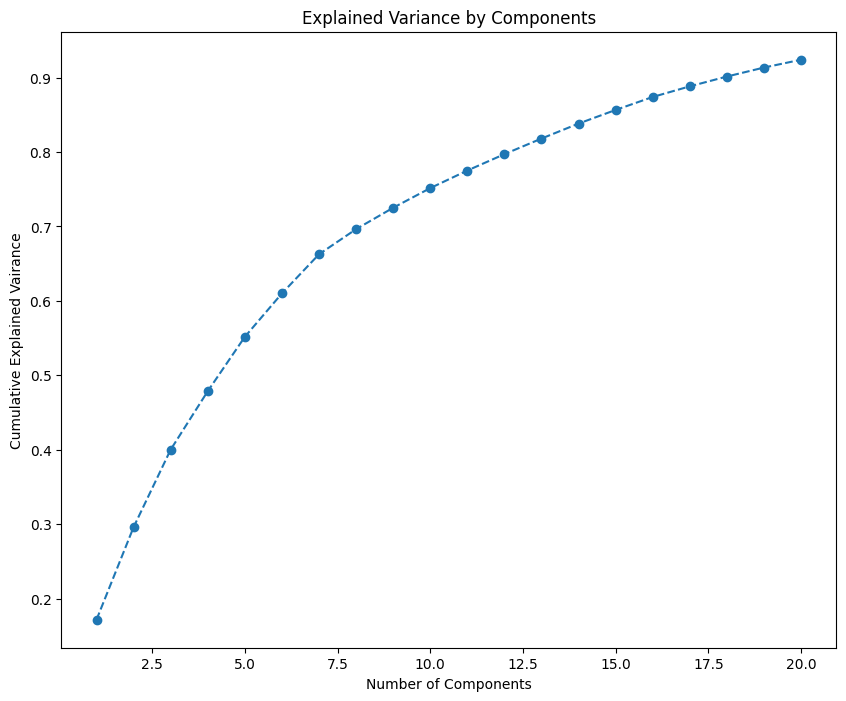

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(outfield_X_train)

explained_variance = pca.explained_variance_ratio_[:20].cumsum()
print(pca.explained_variance_ratio_[:20])

plt.figure(figsize = (10, 8))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker = "o", linestyle = "--")
plt.title("Explained Variance by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Vairance")

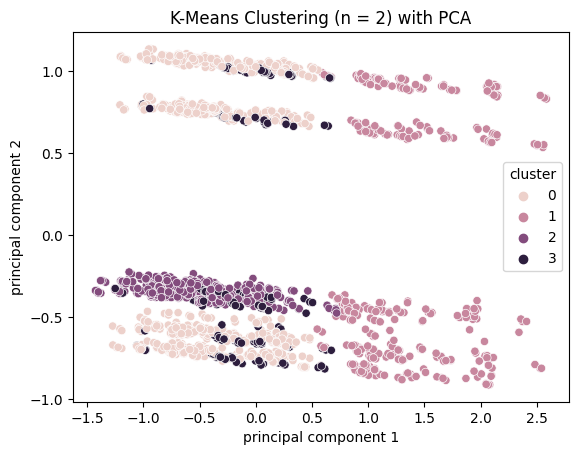

In [7]:
from sklearn.cluster import KMeans
import seaborn as sns

# Apply K-Means clustering (as you did before)
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(outfield_X_train)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
outfield_pca2_X_train = pca.fit_transform(outfield_X_train)
outfield_pca2_X_test = pca.transform(outfield_X_test)
principalDf = pd.DataFrame(data = outfield_pca2_X_train, columns = ['principal component 1', 'principal component 2'])

# Add cluster labels to the principal components DataFrame
principalDf['cluster'] = cluster_labels

# Visualize the clusters using Seaborn
sns.scatterplot(x='principal component 1', y='principal component 2', hue='cluster', data=principalDf)
plt.title('K-Means Clustering (n = 2) with PCA')
plt.show()

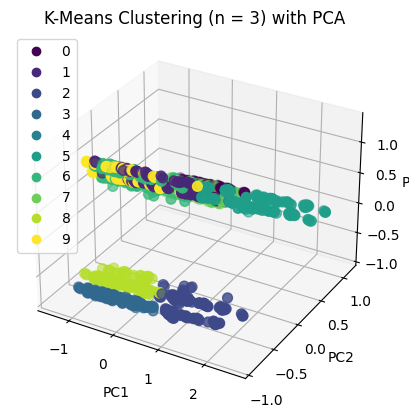

In [8]:
# Apply K-Means clustering (as you did before)
kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(outfield_X_train)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
outfield_pca3_X_train = pca.fit_transform(outfield_X_train)
outfield_pca3_X_test = pca.transform(outfield_X_test)
principalDf = pd.DataFrame(data = outfield_pca3_X_train, columns = ['PCA1', 'PCA2', 'PCA3'])

# Add cluster labels to the principal components DataFrame
principalDf['cluster'] = cluster_labels

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(principalDf['PCA1'], principalDf['PCA2'], principalDf['PCA3'], c=principalDf['cluster'], cmap='viridis', s=50)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.legend(*scatter.legend_elements())
plt.title('K-Means Clustering (n = 3) with PCA')
plt.show()

In [9]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=13)
outfield_pca13_X_train = pca.fit_transform(outfield_X_train)
outfield_pca13_X_test = pca.transform(outfield_X_test)

# Training Different Regression Models
In the follow sections, we try to train different regression models on our data. To evaluate the performance of each regression mode, we can use several scores
* **Mean Squared Error (MSE)**
    * Formula: `MSE = Σ(y_true - y_pred)^2 / n`
    * Range: 0 to infinity
    * Interpretation: Measures the average squared difference between predicted and actual values. Lower values indicate better performance.
    * Sensitivity: Sensitive to outliers due to squaring the errors.
* **Normalized Root Mean Squared Error (NRMSE)**
    * Formula: `NRMSE = RMSE / Mean(y_true)`
    * Range: 0 to infinity
    * Interpretation: Provides a relative measure of error, making it easier to compare models for different target variables. Lower NRMSE values indicate better model performance.
        * An NRMSE value of 1 indicates that the average prediction error is equal to the average value of the target variable.
        * An NRMSE value less than 1 suggests that the model's predictions are better than simply predicting the mean.
    * Sensitivity: Like MSE, sensitive to outliers.
* **Mean Absolute Error (MAE)**
    * Formula: `MAE = Σ|y_true - y_pred| / n`
    * Range: 0 to infinity
    * Interpretation: Measures the average absolute difference between predicted and actual values. Less sensitive to outliers than MSE.
    * Sensitivity: Less sensitive to outliers compared to MSE.
* **R-squared (Coefficient of Determination)**
    * Formula: `R^2 = 1 - (SS_res / SS_tot)`
    * Range: -infinity to 1
    * Interpretation: Represents the proportion of variance in the dependent variable explained by the independent variables. Higher values indicate a better fit.
    * Negative R-squared: Indicates the model is performing worse than simply predicting the mean of the dependent variable.

In [10]:
evaluation_metrics = {'Model': [], 'Target': [], 'Mean Square Error': [], 'Mean Absolute Error': [], 'Normalized Root Mean Square Error': [], 'R-Squared Error': []}
def add_evaluation_metrics(model, target, mse, mae, nrmse, r2):
    evaluation_metrics['Model'].append(model)
    evaluation_metrics['Target'].append(target)
    evaluation_metrics['Mean Square Error'].append(mse)
    evaluation_metrics['Mean Absolute Error'].append(mae)
    evaluation_metrics['Normalized Root Mean Square Error'].append(nrmse)
    evaluation_metrics['R-Squared Error'].append(r2)

## Simple Linear Regression Model

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from termcolor import colored
import numpy as np

def normalized_root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)

targets = ['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']
def get_linear_regression_scores(df_X, df_y, X_test, y_test, target):
    model = LinearRegression()
    model.fit(df_X, df_y[target])

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the MSE
    mse = mean_squared_error(y_test[target], y_pred)

    print("Mean Squared Error for ", target, ":", mse)
          
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
          
    print("Normalised Root Mean Squared Error for ", target, ":", nrmse)
    
    mae = mean_absolute_error(outfield_y_test['Total Days'], y_pred)
    
    print("Mean Absolute Error for ", target, ":", mae)
          
    # Calculate the R-squared score
    r2 = r2_score(y_test[target], y_pred)

    print("R-squared for ", target, ":", r2, "\n")
    
    return (mse, mae, nrmse, r2)

print(colored('All features:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression', target, mse, mae, nrmse, r2)

print(colored('PCA Components with n = 2:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression (PCA n = 2)', target, mse, mae, nrmse, r2)
    
print(colored('PCA Components with n = 3:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression (PCA n = 3)', target, mse, mae, nrmse, r2)
    
print(colored('PCA Components with n = 13:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression (PCA n = 13)', target, mse, mae, nrmse, r2)

All features:
Mean Squared Error for  Total Days : 3030.931202342048
Normalised Root Mean Squared Error for  Total Days : 1.4921604470029501
Mean Absolute Error for  Total Days : 36.93273420479303
R-squared for  Total Days : 0.21897205417730392 

Mean Squared Error for  Total Games Missed : 56.79102307155501
Normalised Root Mean Squared Error for  Total Games Missed : 1.4141519575943684
Mean Absolute Error for  Total Games Missed : 35.702682461873636
R-squared for  Total Games Missed : 0.25110361467390285 

Mean Squared Error for  Injury Count : 1.074276793236826
Normalised Root Mean Squared Error for  Injury Count : 1.0548585824898993
Mean Absolute Error for  Injury Count : 36.57511233660131
R-squared for  Injury Count : 0.1967344458233271 

Mean Squared Error for  Average Injury Cost : 0.018559103602989048
Normalised Root Mean Squared Error for  Average Injury Cost : 1.131771885208982
Mean Absolute Error for  Average Injury Cost : 36.863572729439
R-squared for  Average Injury Cost : 

## K Nearest Neighbours
* Hyperparameters that we can tune: K value, Distance Metrics

### Finding an estimate of the best distance metric
To find a suitable distance metric, we fix and arbitrary K value and iterate through some common metrics. The best metrics will be indicated by the lowest errors achieved.

In [12]:
from sklearn.neighbors import KNeighborsRegressor

metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine', 'chebyshev']  # You can add or remove metrics

# Create empty lists to store performance metrics
mse_scores = []
mae_scores = []
nrmse_scores = []
r2_scores = []

# Loop through each distance metric
for metric in metrics:
    knn_model = KNeighborsRegressor(n_neighbors=5, metric=metric)
    knn_model.fit(outfield_X_train, outfield_y_train['Total Days'])
    y_pred = knn_model.predict(outfield_X_test)

    mse = mean_squared_error(outfield_y_test['Total Days'], y_pred)
    mae = mean_absolute_error(outfield_y_test['Total Days'], y_pred)
    nrmse = normalized_root_mean_squared_error(outfield_y_test['Total Days'], y_pred)
    r2 = r2_score(outfield_y_test['Total Days'], y_pred)

    mse_scores.append(mse)
    mae_scores.append(mae)
    nrmse_scores.append(nrmse)
    r2_scores.append(r2)

print(colored('Detailed Results:', 'black', attrs=['bold']))
for i, metric in enumerate(metrics):
    print(f"\nMetric: {metric}")
    print(f"MSE: {mse_scores[i]:.4f}")
    print(f"NRMSE: {nrmse_scores[i]:.4f}")
    print(f"MAE: {mae_scores[i]:.4f}")
    print(f"R-squared: {r2_scores[i]:.4f}")

Detailed Results:

Metric: euclidean
MSE: 3956.6825
NRMSE: 1.7049
MAE: 40.2745
R-squared: -0.0196

Metric: manhattan
MSE: 4123.5397
NRMSE: 1.7405
MAE: 41.1512
R-squared: -0.0626

Metric: minkowski
MSE: 3956.6825
NRMSE: 1.7049
MAE: 40.2745
R-squared: -0.0196

Metric: cosine
MSE: 3853.0743
NRMSE: 1.6824
MAE: 39.4318
R-squared: 0.0071

Metric: chebyshev
MSE: 3746.1045
NRMSE: 1.6589
MAE: 40.8458
R-squared: 0.0347


### Finding the best K Value for each target
Given a suitable distance metric, to find the best K value we can plot a graph of K against the error (NRMSE). The most suitable value of K will be at the 'elbow point'.

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

def get_knn_error_rates(df_X, df_y, X_test, y_test, target, k=None):
    # Define a range of k values if k is not provided
    neighbors = np.arange(1, 50) if k is None else [k]

    # Create an empty list to store error values
    error_rates = []

    # Loop over k values
    for i in neighbors:
        knn = KNeighborsRegressor(n_neighbors=i, metric='chebyshev')
        knn.fit(df_X, df_y[target])
        y_pred = knn.predict(X_test)
        error = normalized_root_mean_squared_error(y_test[target], y_pred)
        error_rates.append(error)

    # Create a DataFrame to hold the results
    error_df = pd.DataFrame({'k': neighbors, 'error': error_rates})

    # Find the k value with the lowest error (if k is not provided)
    if k is None:
        best_k = error_df.loc[error_df['error'].idxmin(), 'k']
    else:
        best_k = k

    # Create a line plot using Seaborn
    sns.lineplot(x='k', y='error', data=error_df, marker='o')
    plt.title(f'K-Nearest Neighbors: Error Rate vs. K Value for {target}')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Normalized Root Mean Squared Error')
    plt.show()

    return best_k, error_df

def get_best_knn_error_rates(df_X, df_y, X_test, y_test, target, k):
    knn = KNeighborsRegressor(n_neighbors=k, metric='chebyshev')
    knn.fit(df_X, df_y[target])
    y_pred = knn.predict(X_test)
    mse = mean_squared_error(outfield_y_test[target], y_pred)
    mae = mean_absolute_error(outfield_y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(outfield_y_test[target], y_pred)
    r2 = r2_score(outfield_y_test[target], y_pred)
    
    print("Mean Squared Error for ", target, ":", mse)          
    print("Normalised Root Mean Squared Error for ", target, ":", nrmse)    
    print("Mean Absolute Error for ", target, ":", mae)
    print("R-squared for ", target, ":", r2, "\n")

    return mse, mae, nrmse, r2

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


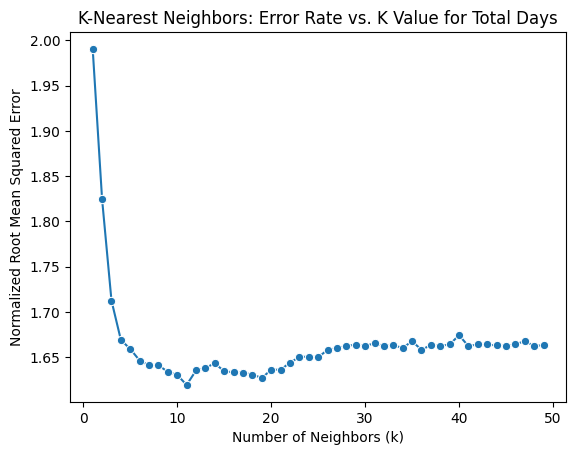

Best K:  11
Smallest Normalised Root MSE:  1.619200373379629
Mean Squared Error for  Total Days : 3568.9973172005257
Normalised Root Mean Squared Error for  Total Days : 1.619200373379629
Mean Absolute Error for  Total Days : 39.639136462665874
R-squared for  Total Days : 0.08032005439585532 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


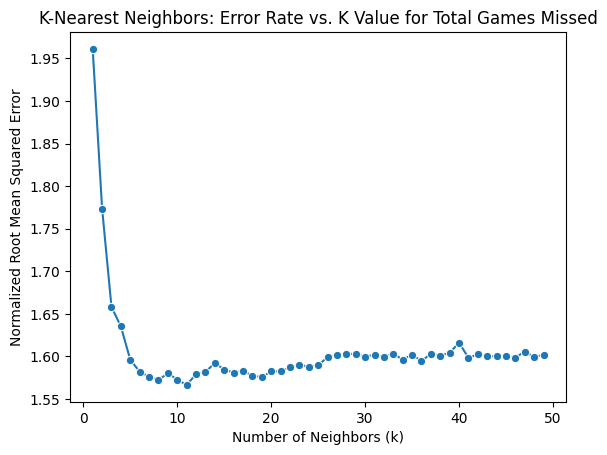

Best K:  11
Smallest Normalised Root MSE:  1.5666261399582908
Mean Squared Error for  Total Games Missed : 69.69767190622805
Normalised Root Mean Squared Error for  Total Games Missed : 1.5666261399582908
Mean Absolute Error for  Total Games Missed : 5.793424440483264
R-squared for  Total Games Missed : 0.08090519006053787 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


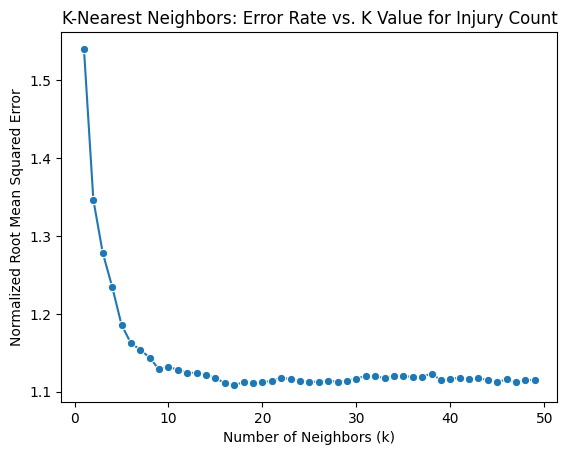

Best K:  17
Smallest Normalised Root MSE:  1.1087868700648518
Mean Squared Error for  Injury Count : 1.1869265968594283
Normalised Root Mean Squared Error for  Injury Count : 1.1087868700648518
Mean Absolute Error for  Injury Count : 0.8459566833269254
R-squared for  Injury Count : 0.11250316808887939 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


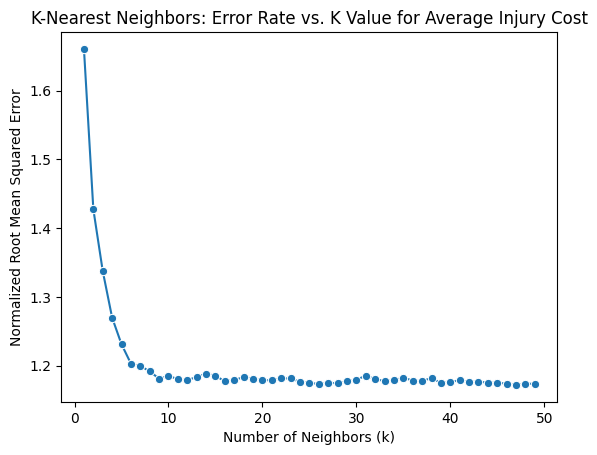

Best K:  47
Smallest Normalised Root MSE:  1.1720869867039876
Mean Squared Error for  Average Injury Cost : 0.0199048487520354
Normalised Root Mean Squared Error for  Average Injury Cost : 1.1720869867039876
Mean Absolute Error for  Average Injury Cost : 0.10886849302368702
R-squared for  Average Injury Cost : 0.07587277975297735 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


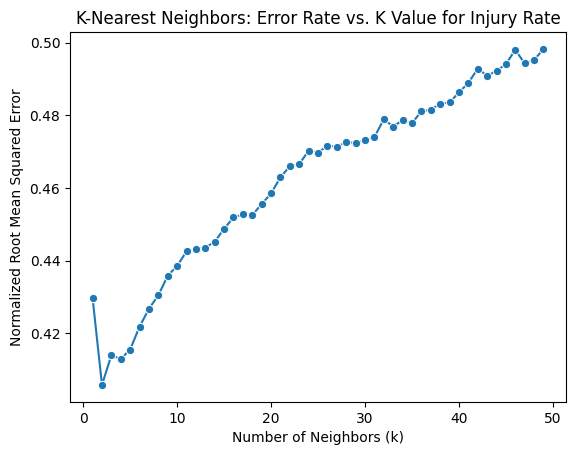

Best K:  2
Smallest Normalised Root MSE:  0.40582242264318896
Mean Squared Error for  Injury Rate : 4.794703809943039e-08
Normalised Root Mean Squared Error for  Injury Rate : 0.40582242264318896
Mean Absolute Error for  Injury Rate : 0.0001327048029095531
R-squared for  Injury Rate : 0.6062556873157394 



In [14]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K', target, mse, mae, nrmse, r2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


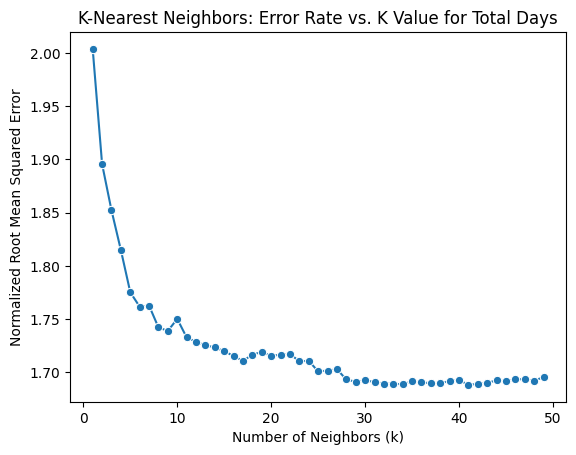

Best K:  41
Smallest Normalised Root MSE:  1.6881448055335362
Mean Squared Error for  Total Days : 3879.398775757246
Normalised Root Mean Squared Error for  Total Days : 1.6881448055335362
Mean Absolute Error for  Total Days : 42.5551835910516
R-squared for  Total Days : 0.00033400477203249235 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


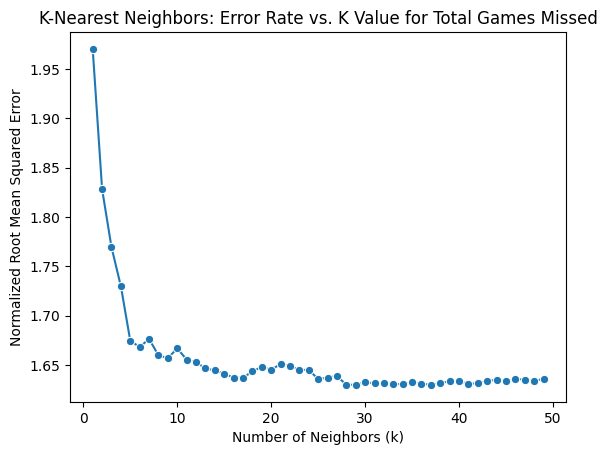

Best K:  37
Smallest Normalised Root MSE:  1.6296422185117845
Mean Squared Error for  Total Games Missed : 75.41748903116154
Normalised Root Mean Squared Error for  Total Games Missed : 1.6296422185117845
Mean Absolute Error for  Total Games Missed : 6.175175175175174
R-squared for  Total Games Missed : 0.005478650126720441 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


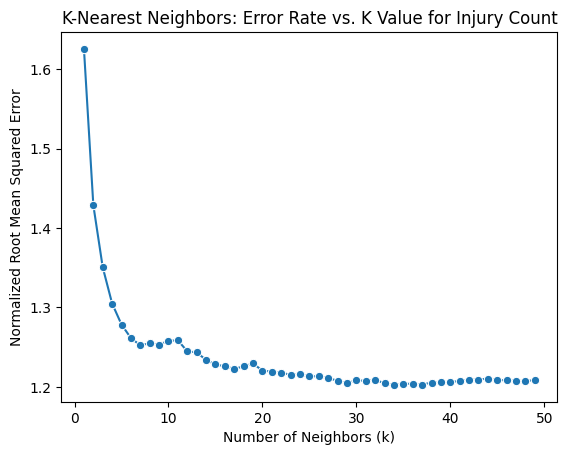

Best K:  34
Smallest Normalised Root MSE:  1.2024257745666111
Mean Squared Error for  Injury Count : 1.3958677280985445
Normalised Root Mean Squared Error for  Injury Count : 1.2024257745666111
Mean Absolute Error for  Injury Count : 0.9174035627322825
R-squared for  Injury Count : -0.04372771638308004 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


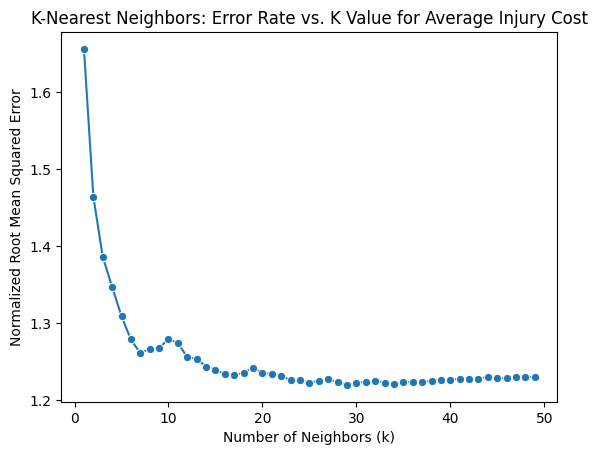

Best K:  29
Smallest Normalised Root MSE:  1.2194990718305774
Mean Squared Error for  Average Injury Cost : 0.021547760602457392
Normalised Root Mean Squared Error for  Average Injury Cost : 1.2194990718305774
Mean Absolute Error for  Average Injury Cost : 0.11563518894147697
R-squared for  Average Injury Cost : -0.0004030855075471962 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


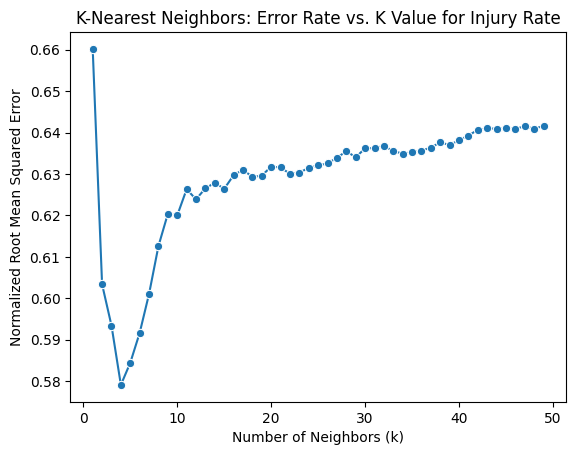

Best K:  4
Smallest Normalised Root MSE:  0.5790663631466039
Mean Squared Error for  Injury Rate : 9.762170362968266e-08
Normalised Root Mean Squared Error for  Injury Rate : 0.5790663631466039
Mean Absolute Error for  Injury Rate : 0.00023100448855155561
R-squared for  Injury Rate : 0.19832398157681774 



In [15]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K (PCA n = 2)', target, mse, mae, nrmse, r2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


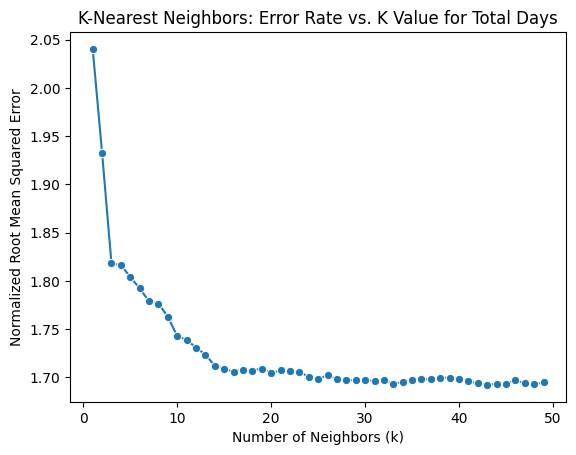

Best K:  43
Smallest Normalised Root MSE:  1.691991297626012
Mean Squared Error for  Total Days : 3897.0975855759043
Normalised Root Mean Squared Error for  Total Days : 1.691991297626012
Mean Absolute Error for  Total Days : 42.36687439833815
R-squared for  Total Days : -0.00422672727806872 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


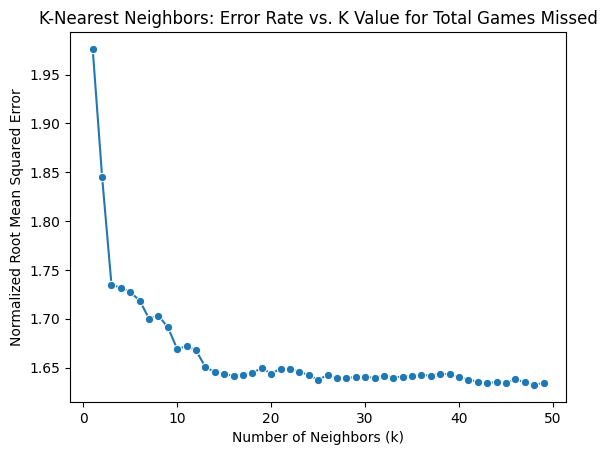

Best K:  48
Smallest Normalised Root MSE:  1.6322090155560438
Mean Squared Error for  Total Games Missed : 75.65525145243284
Normalised Root Mean Squared Error for  Total Games Missed : 1.6322090155560438
Mean Absolute Error for  Total Games Missed : 6.176742919389978
R-squared for  Total Games Missed : 0.0023433056968075183 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


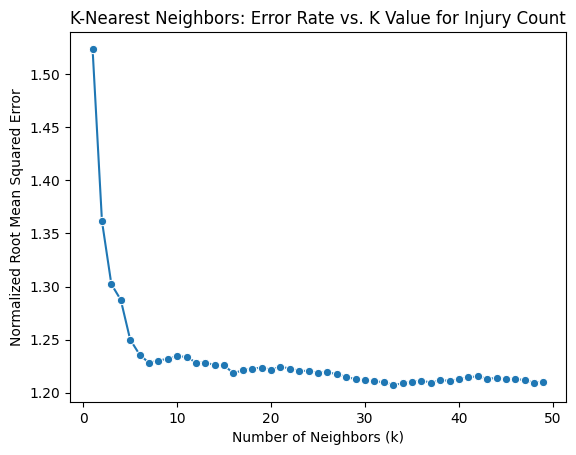

Best K:  33
Smallest Normalised Root MSE:  1.2072991142761313
Mean Squared Error for  Injury Count : 1.4072053471934638
Normalised Root Mean Squared Error for  Injury Count : 1.2072991142761313
Mean Absolute Error for  Injury Count : 0.9162870535419556
R-squared for  Injury Count : -0.0522051580840075 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


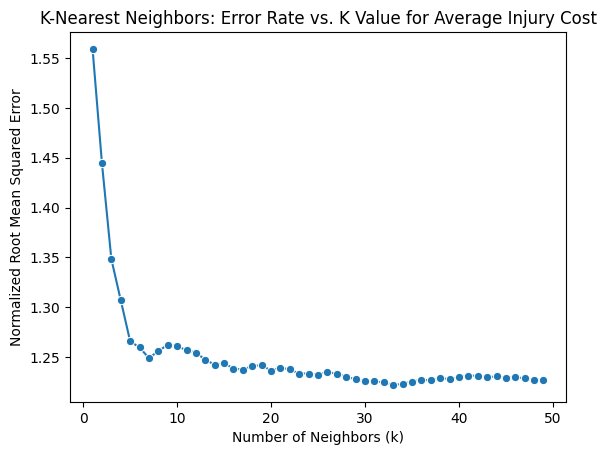

Best K:  33
Smallest Normalised Root MSE:  1.2218618647291715
Mean Squared Error for  Average Injury Cost : 0.021631339539182677
Normalised Root Mean Squared Error for  Average Injury Cost : 1.2218618647291715
Mean Absolute Error for  Average Injury Cost : 0.11551528355449925
R-squared for  Average Injury Cost : -0.004283424988109186 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


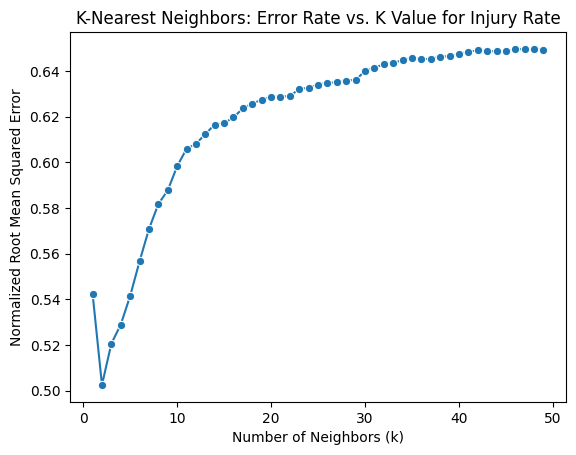

Best K:  2
Smallest Normalised Root MSE:  0.5025377677928661
Mean Squared Error for  Injury Rate : 7.352366006518584e-08
Normalised Root Mean Squared Error for  Injury Rate : 0.5025377677928661
Mean Absolute Error for  Injury Rate : 0.0001560032889197848
R-squared for  Injury Rate : 0.3962187416381465 



In [16]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K (PCA n = 3)', target, mse, mae, nrmse, r2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


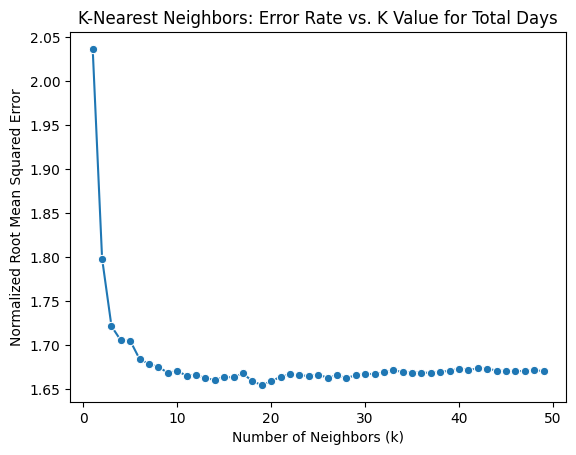

Best K:  19
Smallest Normalised Root MSE:  1.6546620556937954
Mean Squared Error for  Total Days : 3727.036505953566
Normalised Root Mean Squared Error for  Total Days : 1.6546620556937954
Mean Absolute Error for  Total Days : 40.23345946565761
R-squared for  Total Days : 0.03959559887014297 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


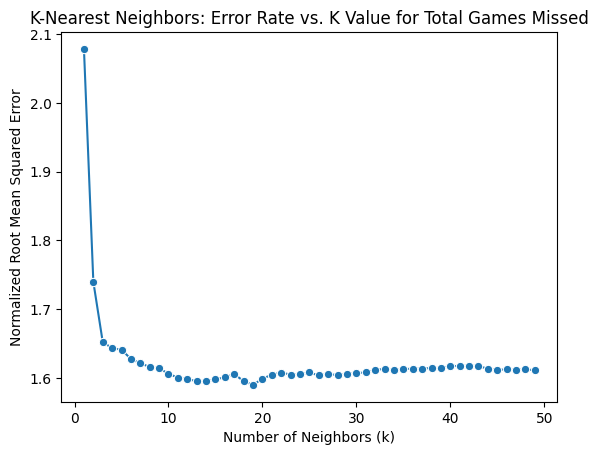

Best K:  19
Smallest Normalised Root MSE:  1.5896699248575745
Mean Squared Error for  Total Games Missed : 71.76314280713827
Normalised Root Mean Squared Error for  Total Games Missed : 1.5896699248575745
Mean Absolute Error for  Total Games Missed : 5.872835683981195
R-squared for  Total Games Missed : 0.05366807391035089 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


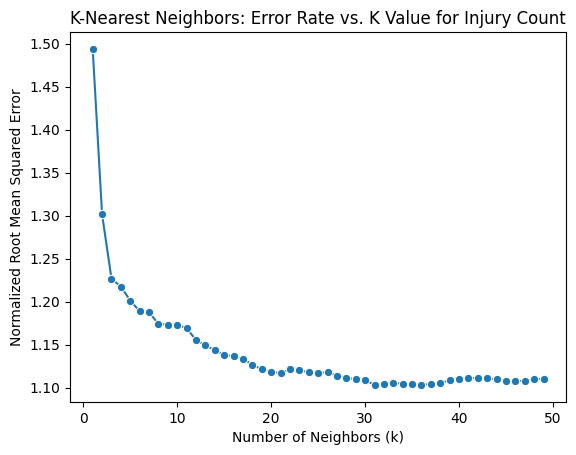

Best K:  36
Smallest Normalised Root MSE:  1.103093024192367
Mean Squared Error for  Injury Count : 1.1747676779902636
Normalised Root Mean Squared Error for  Injury Count : 1.103093024192367
Mean Absolute Error for  Injury Count : 0.8406560154926167
R-squared for  Injury Count : 0.12159471764586183 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


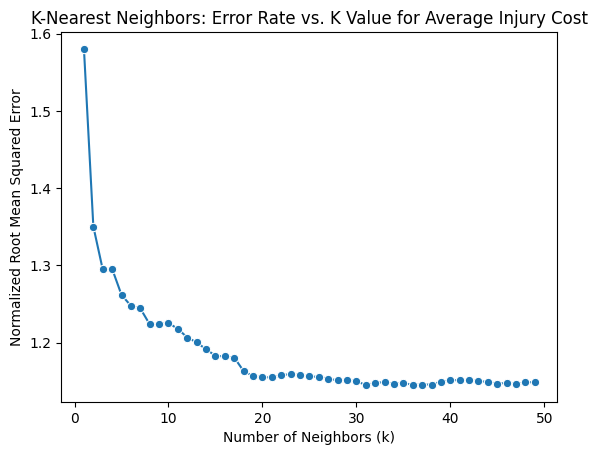

Best K:  31
Smallest Normalised Root MSE:  1.1453516703132165
Mean Squared Error for  Average Injury Cost : 0.01900714556142725
Normalised Root Mean Squared Error for  Average Injury Cost : 1.1453516703132165
Mean Absolute Error for  Average Injury Cost : 0.10747136130437838
R-squared for  Average Injury Cost : 0.11755066258837232 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


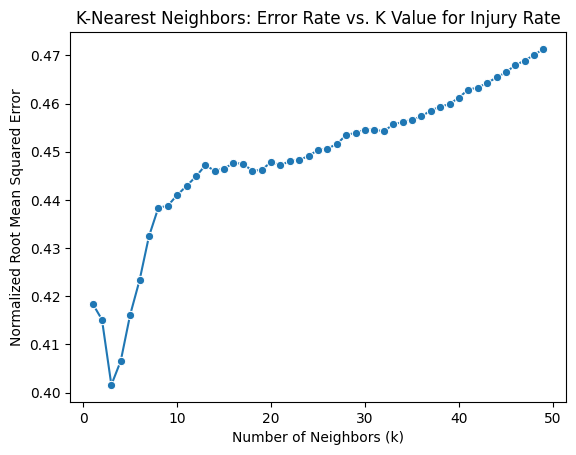

Best K:  3
Smallest Normalised Root MSE:  0.40160874445974276
Mean Squared Error for  Injury Rate : 4.6956533312685754e-08
Normalised Root Mean Squared Error for  Injury Rate : 0.40160874445974276
Mean Absolute Error for  Injury Rate : 0.00013941838405028134
R-squared for  Injury Rate : 0.6143897794708891 



In [17]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K (PCA n = 13)', target, mse, mae, nrmse, r2)

## Decision Tree

In [18]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

def get_decision_tree_error_rates(df_X, df_y, X_test, y_test, target):
    # Create a decision tree model
    dt_model = DecisionTreeRegressor()

    # Fit the model to the training data
    dt_model.fit(df_X, df_y[target])

    # Make predictions on the test set
    y_pred = dt_model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    title = 'Decision Tree Errors for ' + target + ':'
    print(colored(title, 'black', attrs=['bold']))
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')
    
    return mse, mae, nrmse, r2

In [19]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5600.936819172113
MAE: 45.08061002178649
NRMSE: 2.0284197076343387
R-squared: -0.4432819112424806 

Decision Tree Errors for Total Games Missed:
MSE: 104.41394335511983
MAE: 6.466230936819172
NRMSE: 1.9175004819447738
R-squared: -0.376894102748764 

Decision Tree Errors for Injury Count:
MSE: 1.9934640522875817
MAE: 1.0130718954248366
NRMSE: 1.436945669592481
R-squared: -0.49056650648419575 

Decision Tree Errors for Average Injury Cost:
MSE: 0.039202178649237474
MAE: 0.12854030501089325
NRMSE: 1.6448848663234148
R-squared: -0.8200490158983238 

Decision Tree Errors for Injury Rate:
MSE: 9.76337181310176e-14
MAE: 1.4584568062197205e-08
NRMSE: 0.0005791019954869982
R-squared: 0.9999991982253177 



In [20]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree (PCA n = 2)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 6013.803921568628
MAE: 47.694989106753816
NRMSE: 2.1018519235844795
R-squared: -0.5496719027518056 

Decision Tree Errors for Total Games Missed:
MSE: 127.23529411764706
MAE: 7.108932461873638
NRMSE: 2.116703519266152
R-squared: -0.6778365082550302 

Decision Tree Errors for Injury Count:
MSE: 2.784313725490196
MAE: 1.1808278867102397
NRMSE: 1.6982249915968033
R-squared: -1.0819060057779257 

Decision Tree Errors for Average Injury Cost:
MSE: 0.038098257080610015
MAE: 0.13710239651416123
NRMSE: 1.62155975498396
R-squared: -0.7687969826226575 

Decision Tree Errors for Injury Rate:
MSE: 1.566867240394945e-07
MAE: 0.00025099400887711984
NRMSE: 0.7336201432691662
R-squared: -0.2867219521618811 



In [21]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree (PCA n = 3)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5844.045751633987
MAE: 46.72113289760349
NRMSE: 2.071973936977876
R-squared: -0.5059276321302153 

Decision Tree Errors for Total Games Missed:
MSE: 124.59477124183006
MAE: 6.9869281045751634
NRMSE: 2.0946243184833837
R-squared: -0.6430162509305819 

Decision Tree Errors for Injury Count:
MSE: 2.5359477124183005
MAE: 1.093681917211329
NRMSE: 1.6207136544409984
R-squared: -0.896196080379895 

Decision Tree Errors for Average Injury Cost:
MSE: 0.04042875816993464
MAE: 0.14209150326797385
NRMSE: 1.6704197029455987
R-squared: -0.8769957195379527 

Decision Tree Errors for Injury Rate:
MSE: 9.550447515635281e-08
MAE: 0.00015545510157983532
NRMSE: 0.5727525194531186
R-squared: 0.21571080468564108 



In [22]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree (PCA n = 13)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5643.437908496732
MAE: 46.3442265795207
NRMSE: 2.03610120115379
R-squared: -0.45423383864511657 

Decision Tree Errors for Total Games Missed:
MSE: 113.02832244008715
MAE: 6.631808278867102
NRMSE: 1.9950320352819588
R-squared: -0.4904908828319885 

Decision Tree Errors for Injury Count:
MSE: 1.8954248366013071
MAE: 0.954248366013072
NRMSE: 1.4011654734711985
R-squared: -0.41725995698497287 

Decision Tree Errors for Average Injury Cost:
MSE: 0.03178235294117647
MAE: 0.12315904139433552
NRMSE: 1.481062637676475
R-squared: -0.47556697578201046 

Decision Tree Errors for Injury Rate:
MSE: 1.3435750648335535e-08
MAE: 3.428990505868613e-05
NRMSE: 0.21482564022552947
R-squared: 0.8896647089345686 



## Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor

def get_random_forest_error_rates(df_X, df_y, X_test, y_test, target):
    # Create a random forest model
    rf_model = RandomForestRegressor(n_estimators=100)
      # Adjust n_estimators as needed

    # Fit the model to the training data
    rf_model.fit(df_X, df_y[target])

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)
    
    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    title = 'Random Forest Errors for ' + target + ':'
    print(colored(title, 'black', attrs=['bold']))
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')
    
    return mse, mae, nrmse, r2

In [29]:
for target in targets:
    mse, mae, nrmse, r2 = get_random_forest_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest', target, mse, mae, nrmse, r2)

Random Forest Errors for Total Days:
MSE: 3047.2675912854024
MAE: 36.55825708061002
NRMSE: 1.4961763340914502
R-squared: 0.21476239864677604 

Random Forest Errors for Total Games Missed:
MSE: 55.464201742919386
MAE: 5.168235294117648
NRMSE: 1.3975347524371178
R-squared: 0.2686002478255335 

Random Forest Errors for Injury Count:
MSE: 1.0736790849673201
MAE: 0.8022004357298476
NRMSE: 1.0545650894973662
R-squared: 0.1971813683179423 

Random Forest Errors for Average Injury Cost:
MSE: 0.017803262461873633
MAE: 0.10283812636165578
NRMSE: 1.1084859692906204
R-squared: 0.17344363400213858 

Random Forest Errors for Injury Rate:
MSE: 4.691225994291306e-11
MAE: 3.65530427531647e-07
NRMSE: 0.012693995051229033
R-squared: 0.9996147533553713 



In [24]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest (PCA n = 2)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 6502.259259259259
MAE: 49.570806100217865
NRMSE: 2.1855443582485585
R-squared: -0.6755399094976717 

Decision Tree Errors for Total Games Missed:
MSE: 120.47494553376906
MAE: 6.871459694989107
NRMSE: 2.059703002839691
R-squared: -0.5886886052205724 

Decision Tree Errors for Injury Count:
MSE: 2.747276688453159
MAE: 1.1786492374727668
NRMSE: 1.6868922546601648
R-squared: -1.0542124204115528 

Decision Tree Errors for Average Injury Cost:
MSE: 0.03891895424836601
MAE: 0.1387363834422658
NRMSE: 1.638932186561598
R-squared: -0.8068996882373081 

Decision Tree Errors for Injury Rate:
MSE: 1.5409902079966613e-07
MAE: 0.00024301218792598312
NRMSE: 0.7275370029082633
R-squared: -0.2654715585195435 



In [25]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest (PCA n = 3)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 6028.244008714597
MAE: 47.0239651416122
NRMSE: 2.1043738487958246
R-squared: -0.5533929082277471 

Decision Tree Errors for Total Games Missed:
MSE: 124.12854030501089
MAE: 6.895424836601308
NRMSE: 2.090701625958201
R-squared: -0.6368681196868262 

Decision Tree Errors for Injury Count:
MSE: 2.4989106753812638
MAE: 1.091503267973856
NRMSE: 1.6088350152952253
R-squared: -0.8685024950135218 

Decision Tree Errors for Average Injury Cost:
MSE: 0.041080174291939
MAE: 0.1428322440087146
NRMSE: 1.6838234052319625
R-squared: -0.9072391731582885 

Decision Tree Errors for Injury Rate:
MSE: 1.063149909820604e-07
MAE: 0.0001683777881652643
NRMSE: 0.6042997303689774
R-squared: 0.12693411915339903 



In [26]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest (PCA n = 13)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5517.156862745098
MAE: 45.87581699346405
NRMSE: 2.0131917894441895
R-squared: -0.4216930057540471 

Decision Tree Errors for Total Games Missed:
MSE: 111.83660130718954
MAE: 6.5773420479302835
NRMSE: 1.9844867934786632
R-squared: -0.47477579969958494 

Decision Tree Errors for Injury Count:
MSE: 1.8278867102396514
MAE: 0.9389978213507625
NRMSE: 1.3759757540616788
R-squared: -0.3667598895521751 

Decision Tree Errors for Average Injury Cost:
MSE: 0.033558605664488025
MAE: 0.12479302832244009
NRMSE: 1.5218868242228547
R-squared: -0.5580334899514414 

Decision Tree Errors for Injury Rate:
MSE: 1.1178084324172977e-08
MAE: 2.9999899443549085e-05
NRMSE: 0.19594709888513936
R-squared: 0.9082048171521886 



## Neural Network

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

results = {
    "Loss Function": [],
    "Hidden Layers": [],
    "Epochs": [],
    "Batch Size": [],
    "Neurons per hidden layer": [],
    "MSE": [],
    "MAE": [],
    "NRMSE": [],
    "R-squared": []
}

hyperparameter_grid = {
    'loss_functions': ['mean_squared_error', 'mean_absolute_error', 'cosine_similarity', 'huber', 'log_cosh'],
    'hidden_layers': [1, 2, 3],  # Number of hidden layers
    'epochs': [50, 100, 200],  # Training epochs
    'batch_size': [64, 128, 256],  # Batch size
    'neurons_per_layer': [32, 64]
}

def get_nn_error_rates(df_X, df_y, X_test, y_test, target):
    # Loop through different loss functions
    for loss_func in loss_functions:
        print(f"Using loss function: {loss_func}")
        for hidden_layers in hyperparameter_grid['hidden_layers']:
            for epochs in hyperparameter_grid['epochs']:
                for batch_size in hyperparameter_grid['batch_size']:
                    for neurons_per_layer in hyperparameter_grid['neurons_per_layer']:
                        print(f"Loss function: {loss_func}, Hidden layers: {hidden_layers}, Epochs: {epochs}, Batch size: {batch_size}, Neurons per layer: {neurons_per_layer}")
                        
                        # Create the model
                        model = Sequential()
                        model.add(Input(shape=(df_X.shape[1],)))

                        for _ in range(hidden_layers):
                            model.add(Dense(neurons_per_layer, activation='relu'))

                        model.add(Dense(1)) # output layer

                        model.compile(loss=loss_func, optimizer='adam')
                        model.fit(df_X, df_y, epochs=200, batch_size=128, verbose=0)

                        # Evaluate on validation set (optional)
                        val_loss = model.evaluate(df_X, df_y, verbose=0)
                        print(f"Training Loss: {val_loss}")

                        # Evaluate on test set
                        y_pred = model.predict(X_test)

                        mse = mean_squared_error(y_test[target], y_pred)
                        mae = mean_absolute_error(y_test[target], y_pred)
                        nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
                        r2 = r2_score(y_test[target], y_pred)

                        # Print performance metrics
                        print(f"Test Set Performance ({loss_func}):")
                        print("MSE:", mse)
                        print("MAE:", mae)
                        print("NRMSE:", nrmse)
                        print("R-squared:", r2, '\n')

                        # Prepare data for visualization (optional)
                        results['Loss Function'].append(loss_func)
                        results['Hidden Layers'].append(hidden_layers)
                        results['Epochs'].append(epochs)
                        results['Batch Size'].append(batch_size)
                        results['Neurons per hidden layer'].append(neurons_per_layer)

                        results['MSE'].append(mse)
                        results['MAE'].append(mae)
                        results['NRMSE'].append(nrmse)
                        results['R-squared'].append(r2)

    return pd.DataFrame(results)
    
def create_nn_performance_chart(results_df, x_metric, y_metric):
    # Create Seaborn bar plot
    sns.barplot(x=x_metric, y=y_metric, data=loss_function_results_df)
    plt.title(f'Neural Network Performance by {y_metric} against {x_metric}')
    plt.xlabel(f'{x_metric}')
    plt.xticks(rotation=90)
    plt.ylabel('Performance Metric')
    plt.show()

In [32]:
def print_overall_nn_min_stats(df, title):
    print(colored(title, 'black', attrs=['bold']))
    print(df.idxmin(), '\n')
    
def print_nn_model_by_index(df, index):
    print(df.loc[[index]])

In [35]:
print_overall_nn_min_stats(nn_results_df, 'Neural Network Performance Summary (Min.)')

Neural Network Performance Summary (Min.)
Model                         0
Loss Function               108
Hidden Layers                 0
Epochs                        0
Batch Size                    0
Neurons per hidden layer      0
MSE                          66
MAE                          66
NRMSE                        66
R-squared                    49
dtype: int64 



In [34]:
nn_results_df.loc[[66]]

,Model,Loss Function,Hidden Layers,Epochs,Batch Size,Neurons per hidden layer,MSE,MAE,NRMSE,R-squared
66,Neural Network,mean_absolute_error,1,200,64,32,0.088687,0.202773,551.931375,-728302.472257


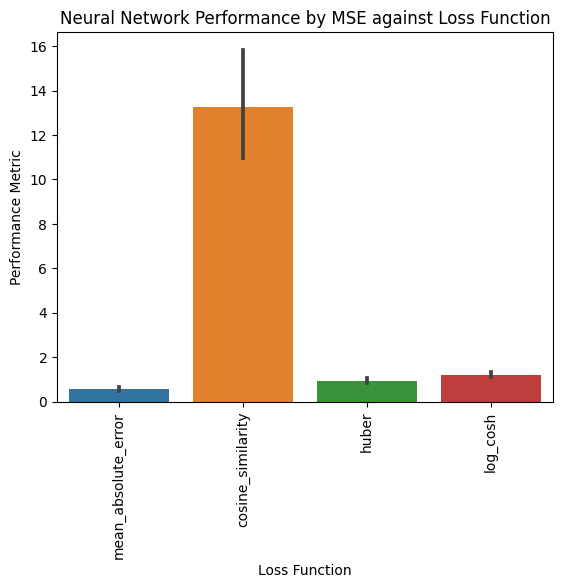

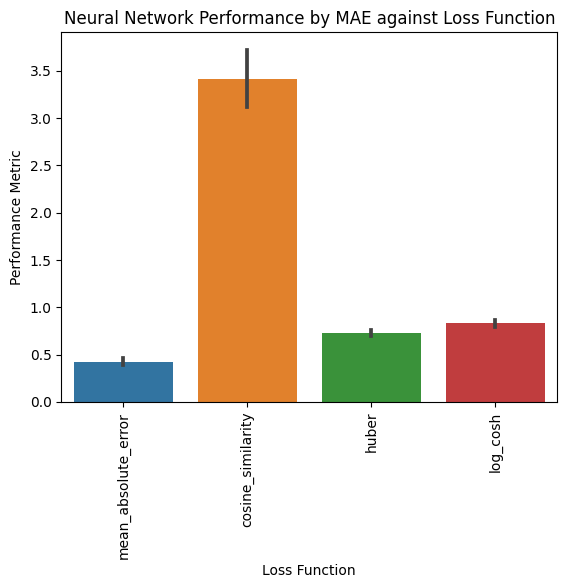

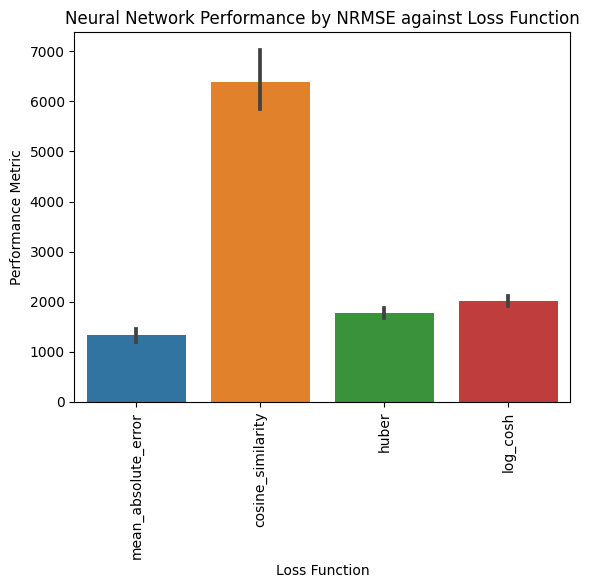

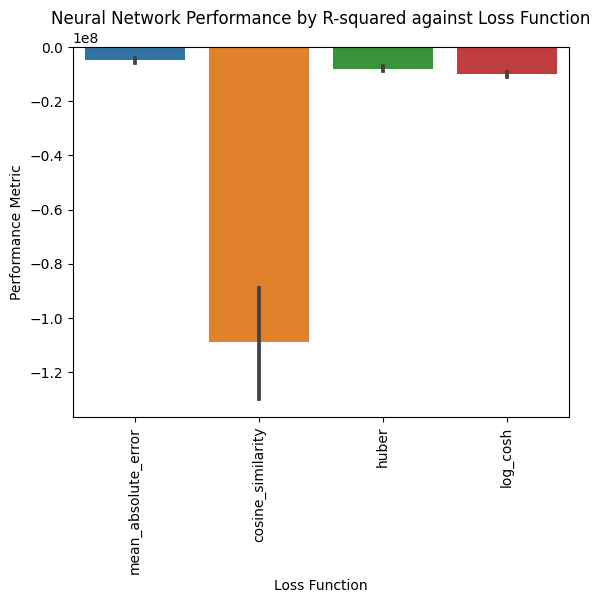

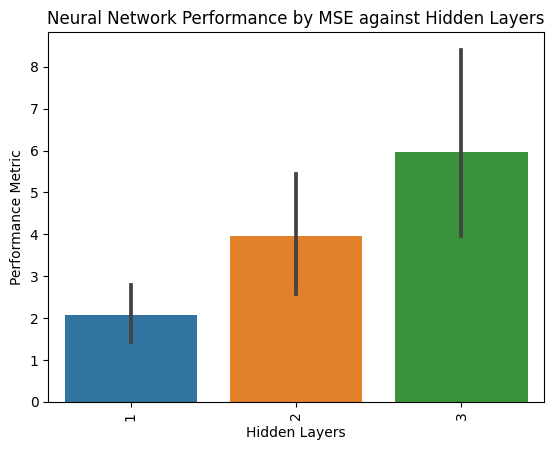

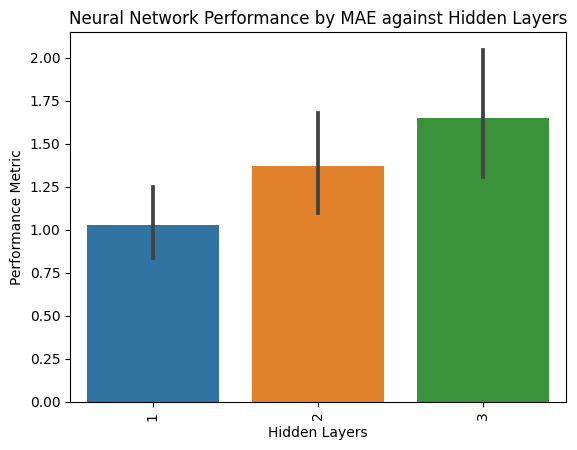

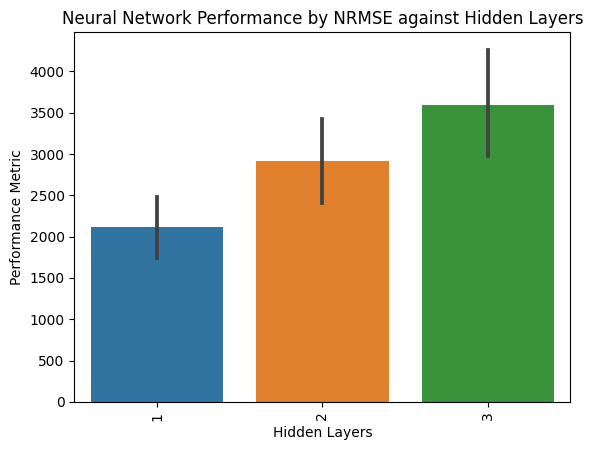

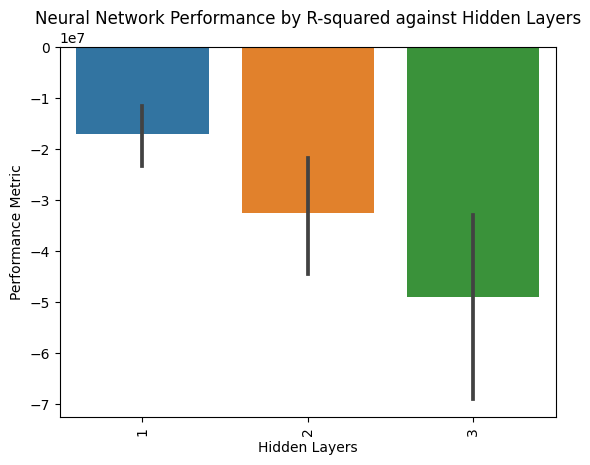

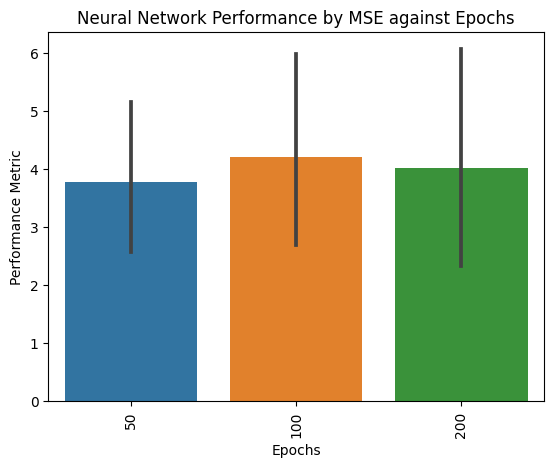

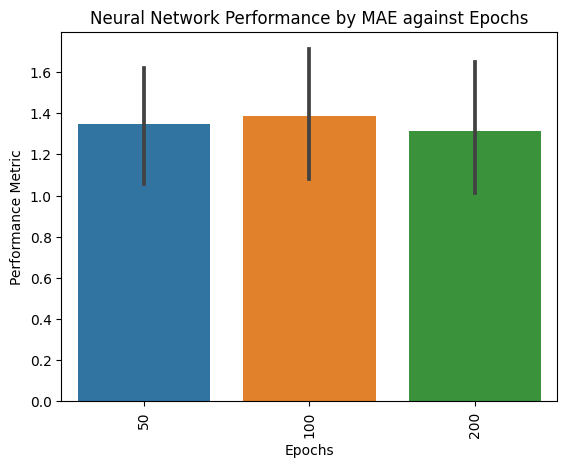

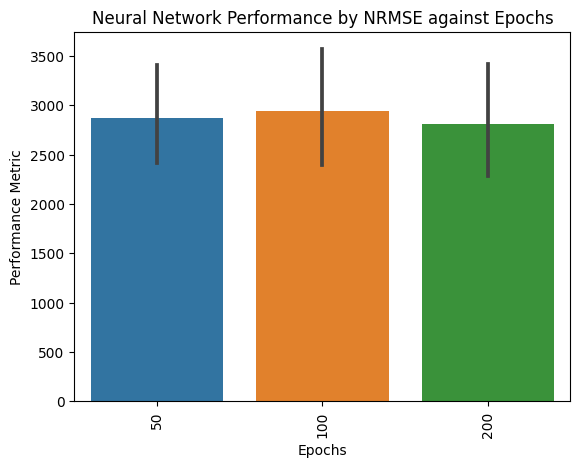

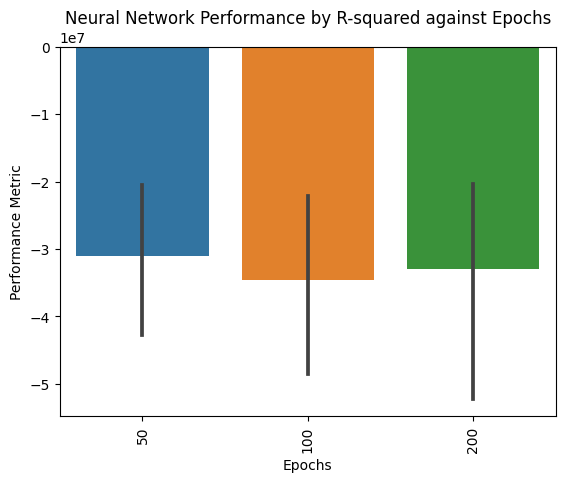

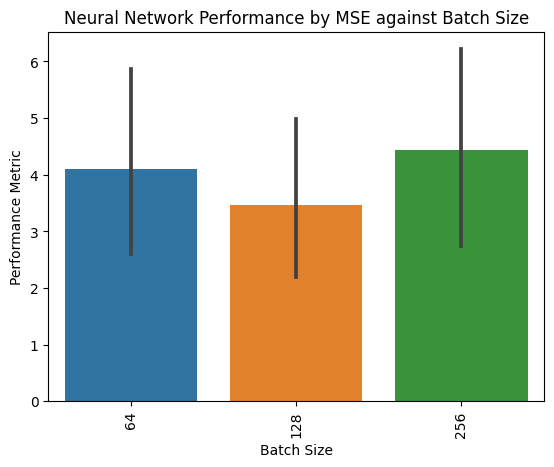

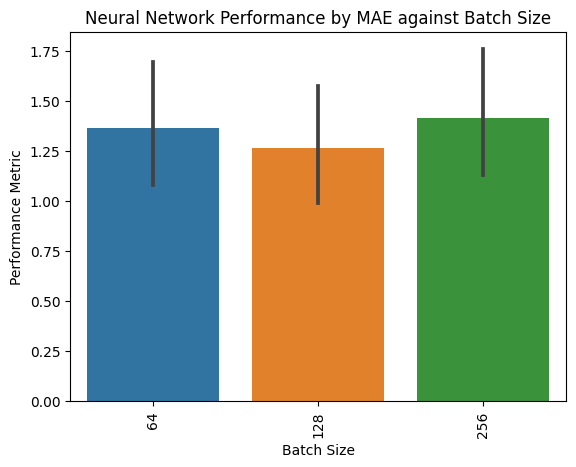

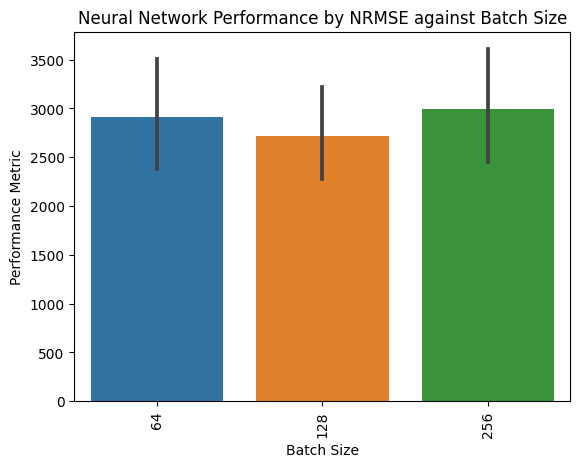

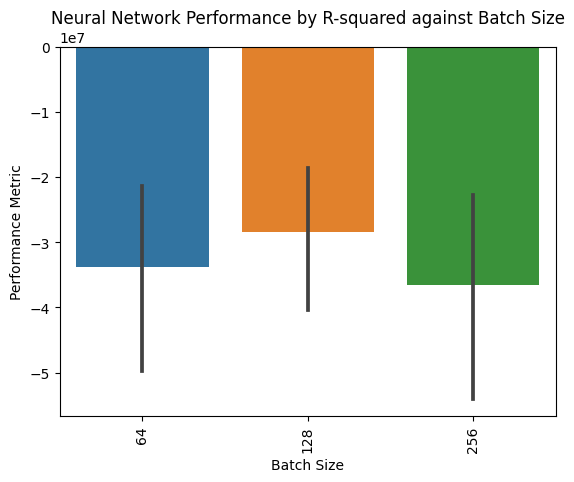

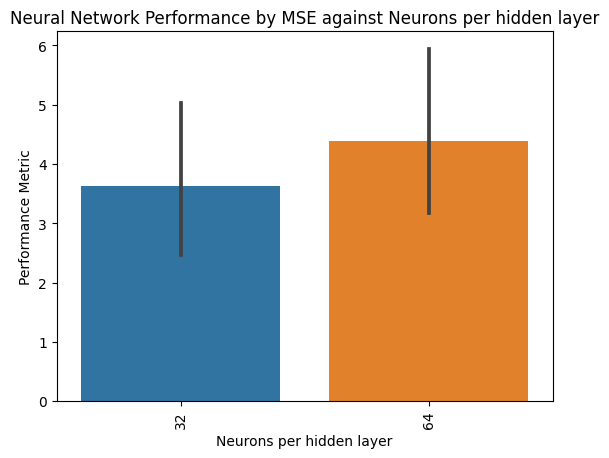

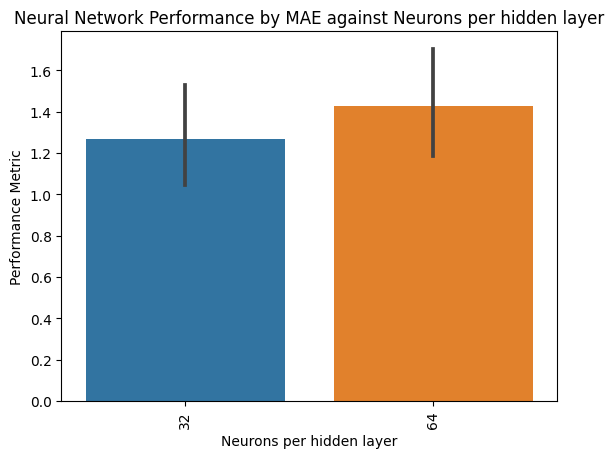

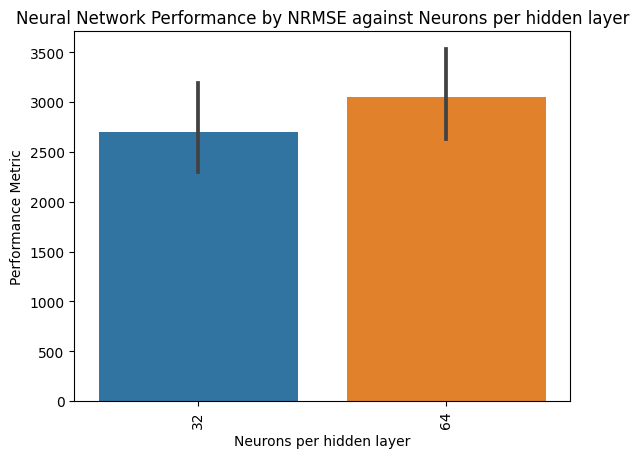

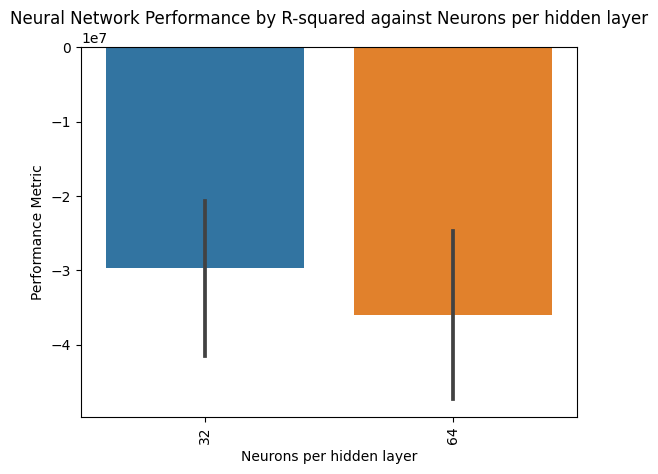

In [30]:
y_metrics = ["MSE", "MAE", "NRMSE", "R-squared"]
x_metrics = ["Loss Function", "Hidden Layers", "Epochs", "Batch Size", "Neurons per hidden layer"]
loss_function_results_df = nn_results_df[nn_results_df['Loss Function'] != 'mean_squared_error']

for x_metric in x_metrics:
    if x_metric == "Loss Function":
        df = nn_results_df[nn_results_df['Loss Function'] != 'mean_squared_error']
    else:
        df = nn_results_df
    for y_metric in y_metrics:
        create_nn_performance_chart(df, x_metric, y_metric)

In [ ]:
# nn_results_df = get_nn_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
# nn_results_df.to_csv('nn_results.csv', index=False)

In [ ]:
pca2_nn_results_df = get_nn_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
pca2_nn_results_df.to_csv('pca2_nn_results.csv', index=False)

In [ ]:
pca3_nn_results_df = get_nn_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
pca3_nn_results_df.to_csv('pca3_nn_results.csv', index=False)

In [ ]:
pca13_nn_results_df = get_nn_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
pca13_nn_results_df.to_csv('pca13_nn_results.csv', index=False)

# Comparing the performance of different models
Now that we have several models, we can compare the performance of these models by plotting a graph of Evaluation Metrics against Model, for each target that we are trying to predict.

In [35]:
eval_metrics_df = pd.DataFrame(evaluation_metrics)
eval_metrics_df.to_csv('model_performance.csv', index = False)

In [36]:
def plot_model_comparison(df, x, target):
    """
    Plots the performance of different models for a specific target variable.

    Args:
    df: DataFrame containing model performance metrics.
    target: Target variable to focus on.
    """

    # Filter data for the specified target
    target_df = df[df['Target'] == target]

    # Create a bar plot using Seaborn
    plt.figure(figsize=(8, 6))
    sns.barplot(x=x, y='Model', data=target_df, orient='h')
    plt.title(f'Model Performance by {target}')
    plt.xlabel(f'{x}')
    plt.ylabel('Model')
    plt.show()


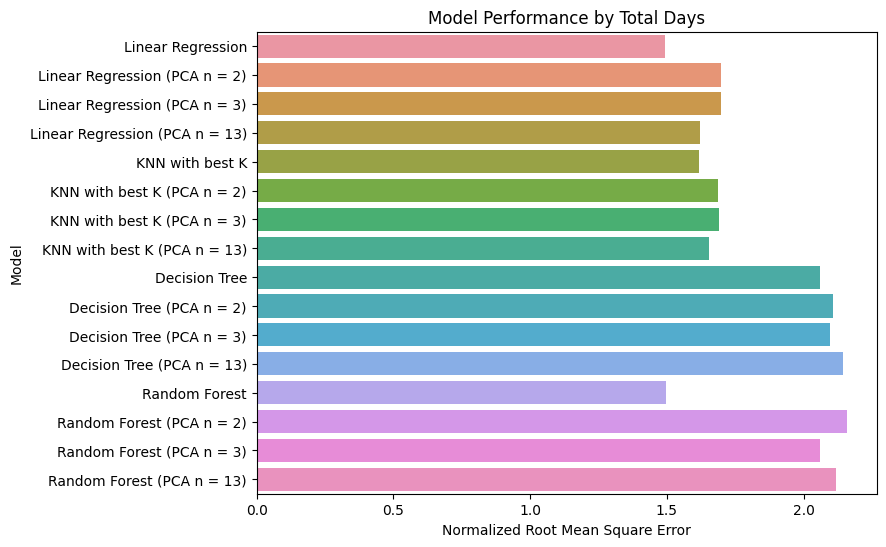

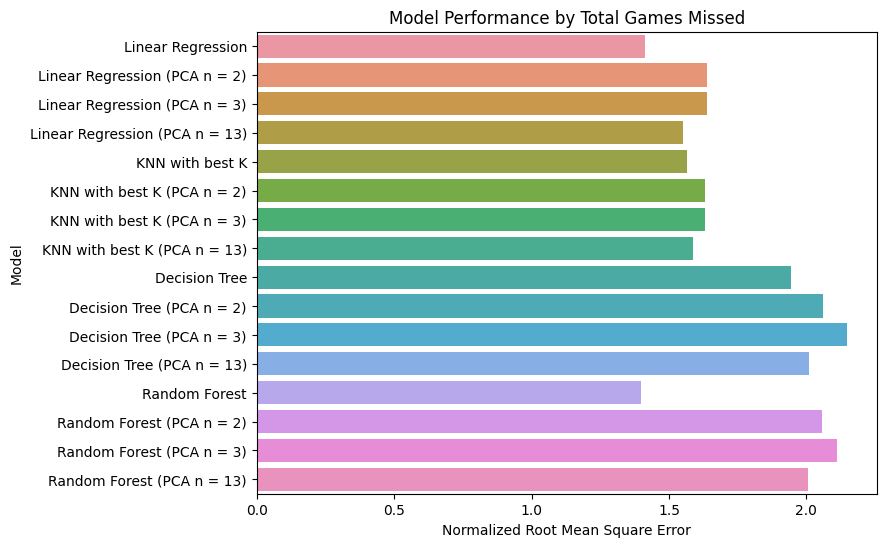

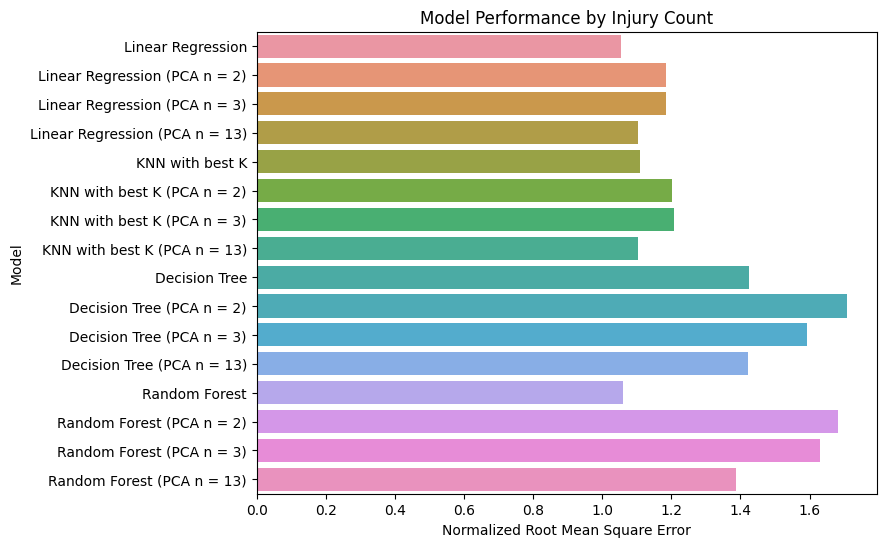

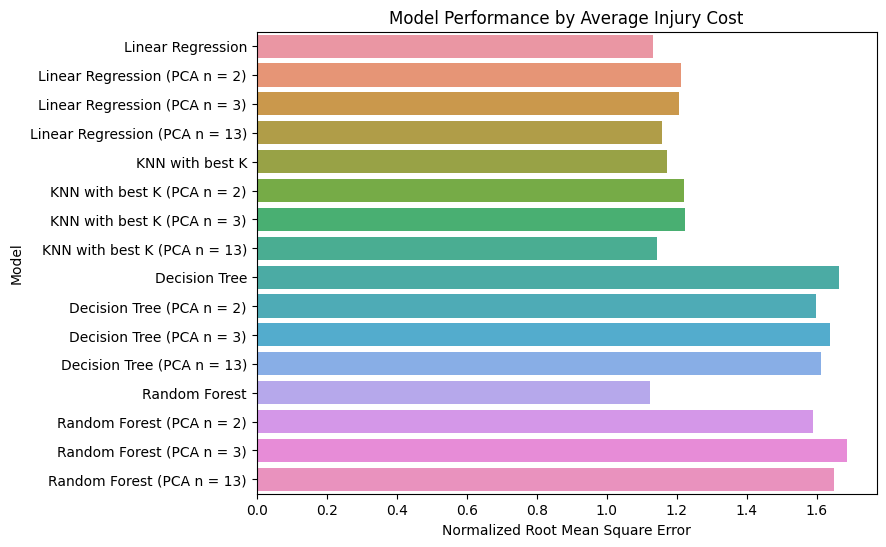

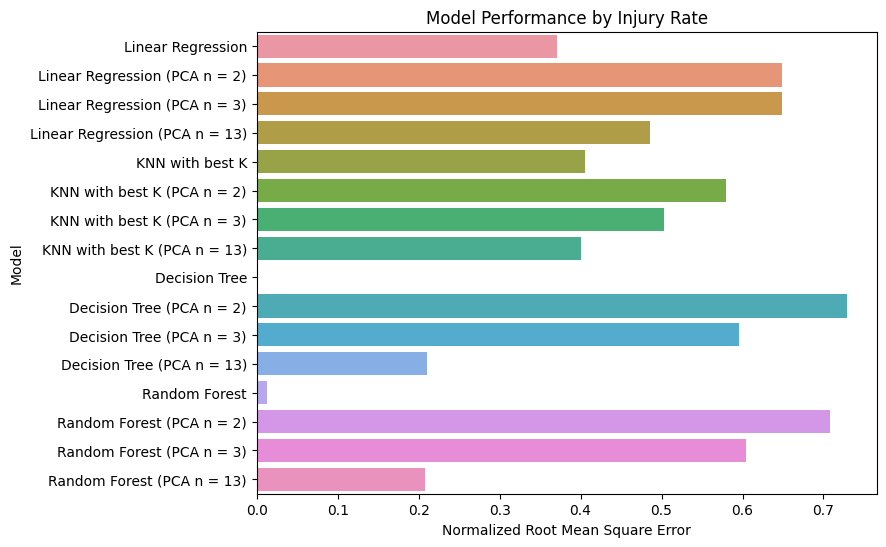

In [37]:
for target in targets:
    plot_model_comparison(model_performance_df, 'Normalized Root Mean Square Error', target)

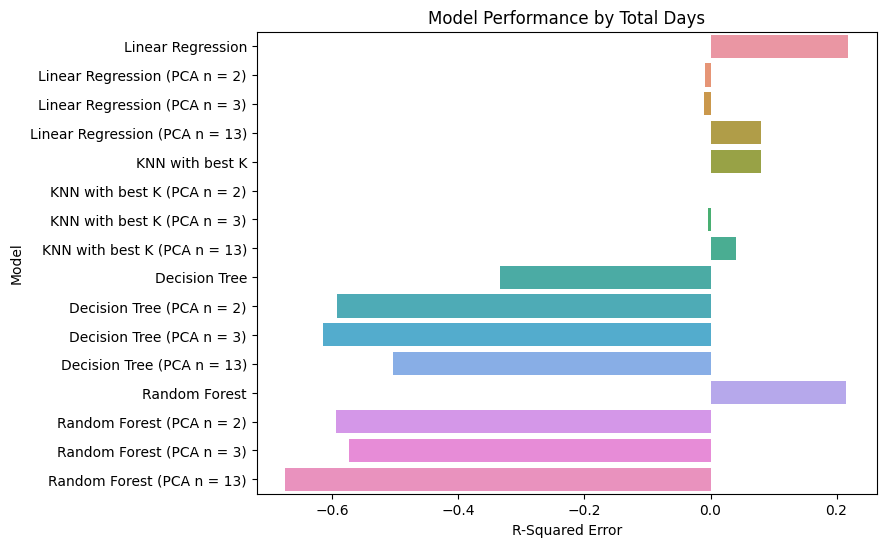

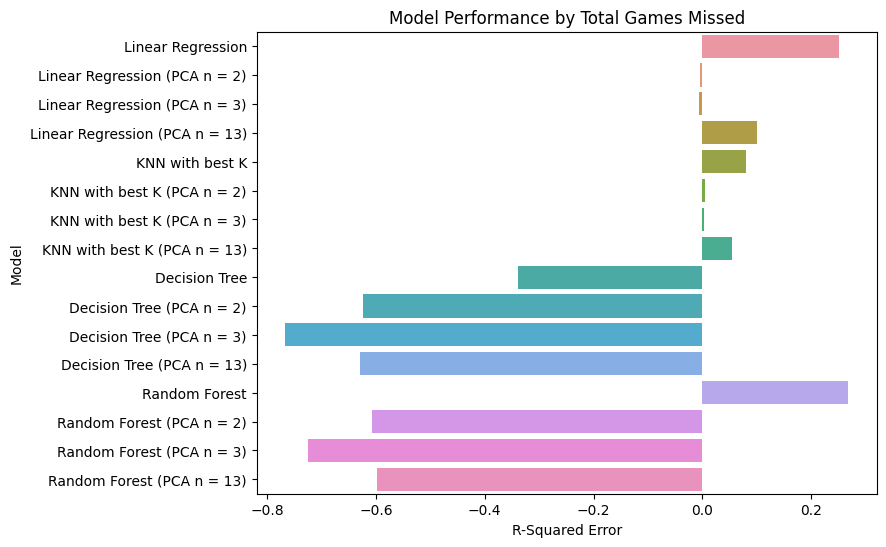

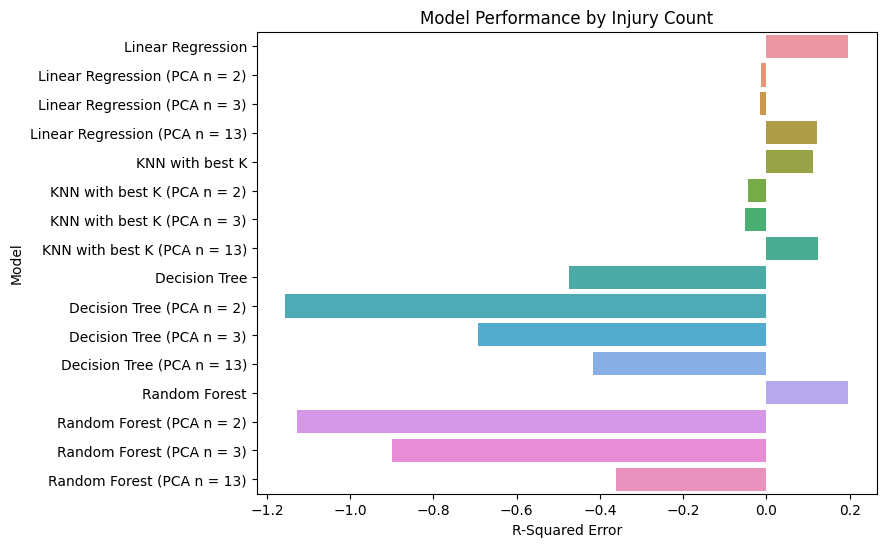

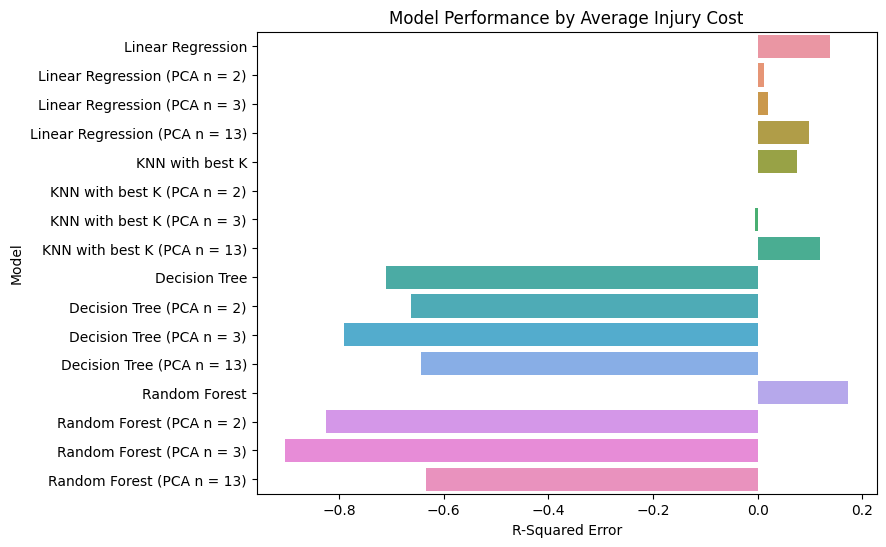

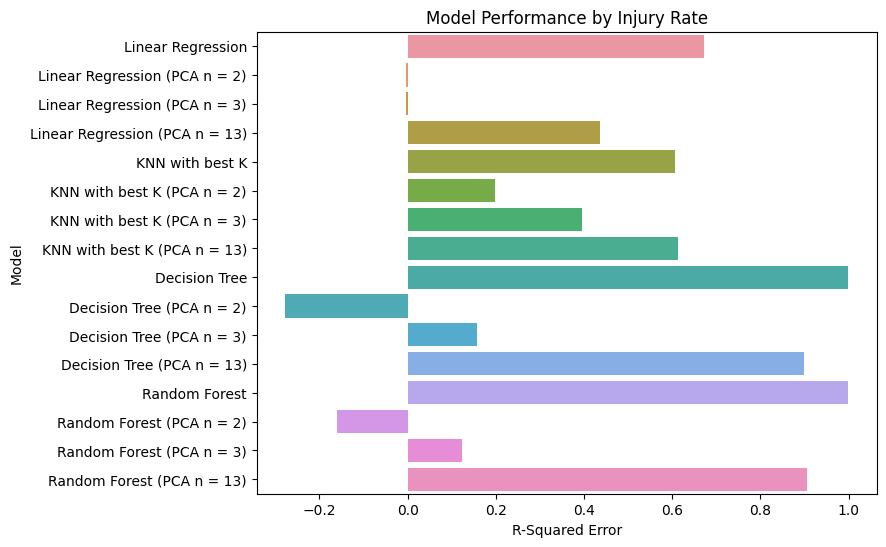

In [38]:
for target in targets:
    plot_model_comparison(eval_metrics_df, 'R-Squared Error', target)